<a href="https://colab.research.google.com/github/dbamman/nlp21/blob/master/HW2/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
import sys, argparse
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import re
from collections import Counter, defaultdict
import operator
import nltk
import csv
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from pandas import option_context

In [145]:
!python -m nltk.downloader punkt

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Let's download the data we'll use for training and development, and also the data we'll use to make predictions for.

In [146]:
# Get data
!wget https://raw.githubusercontent.com/dbamman/nlp21/main/HW2/train.txt
!wget https://raw.githubusercontent.com/dbamman/nlp21/main/HW2/dev.txt
!wget https://raw.githubusercontent.com/dbamman/nlp21/main/HW2/test.txt

--2021-02-02 04:33:58--  https://raw.githubusercontent.com/dbamman/nlp21/main/HW2/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1322055 (1.3M) [text/plain]
Saving to: ‘train.txt.5’

train.txt.5         100%[===================>]   1.26M  --.-KB/s    in 0.08s   

2021-02-02 04:33:58 (15.2 MB/s) - ‘train.txt.5’ saved [1322055/1322055]

--2021-02-02 04:33:58--  https://raw.githubusercontent.com/dbamman/nlp21/main/HW2/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1309909 (1.2M) [text/plain]
Saving to: ‘dev.txt.5’

dev.txt.

In [147]:
trainingFile = "train.txt"
evaluationFile = "dev.txt"
testFile = "test.txt"

In [148]:
######################################################################
## Do not edit this block of code.
## This defines the classification class which
## loads the data and sets up the model.
######################################################################

class Classifier:

    def __init__(self, feature_method, L2_regularization_strength=1.0, min_feature_count=1):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.log_reg = None
        self.L2_regularization_strength=L2_regularization_strength
        self.min_feature_count=min_feature_count

        self.trainX, self.trainY, self.trainOrig = self.process(trainingFile, training=True)
        self.devX, self.devY, self.devOrig = self.process(evaluationFile, training=False)
        self.testX, _, self.testOrig = self.process(testFile, training=False)

    # Read data from file
    def load_data(self, filename):
        data = []
        with open(filename, encoding="utf8") as file:
            for line in file:
                cols = line.split("\t")
                idd = cols[0]
                label = cols[1]
                text = cols[2]

                data.append((idd, label, text))
                
        return data

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for idd, label, text in data:
            feats = self.feature_method(text)
            featurized_data.append((label, feats))
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, dataFile, training = False):
        original_data = self.load_data(dataFile)
        data = self.featurize(original_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for label, feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (label, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = label

        return X, Y, original_data

    def load_test(self, dataFile):
        data = self.load_data(dataFile)
        data = self.featurize(data)

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (data_id, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = data_id

        return X, Y

    # Train model and evaluate on held-out data
    def evaluate(self):
        (D,F) = self.trainX.shape
        self.log_reg = linear_model.LogisticRegression(C = self.L2_regularization_strength, max_iter=1000)
        self.log_reg.fit(self.trainX, self.trainY)
        training_accuracy = self.log_reg.score(self.trainX, self.trainY)
        development_accuracy = self.log_reg.score(self.devX, self.devY)
        print("Method: %s, Features: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (self.feature_method.__name__, F, training_accuracy, development_accuracy))


    # Predict labels for new data
    def predict(self):
        predX = self.log_reg.predict(self.testX)

        with open("%s_%s" % (self.feature_method.__name__, "predictions.csv"), "w", encoding="utf8") as out:
            writer=csv.writer(out)
            writer.writerow(["Id", "Expected"])
            for idx, data_id in enumerate(self.testX):
                writer.writerow([self.testOrig[idx][0], predX[idx]])
        out.close()


    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

*First*, let's define a classifier based on a really simple dictionary-based feature: if the abstract contains the words "love" or "like", the CONTAINS_POSITIVE_WORD feature will fire, and if it contains either "hate" or "dislike", the CONTAINS_NEGATIVE_WORD will fire.  Note how we use `nltk.word_tokenize` to tokenize the text into its discrete words.

In [149]:
def simple_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        if word == "love" or word == "like":
            feats["contains_positive_word"] = 1
        if word == "hate" or word == "dislike":
            feats["contains_negative_word"] = 1
            
    return feats


Now let's see how that feature performs on the development data.  Note the `L2_regularization_strength` specifies the strength of the L2 regularizer (values closer to 0 = stronger regularization), and the `min_feature_count` specifies how many data points need to contain a feature for it to be allowable as a feature in the model.  Both are ways to prevent the model from overfitting and achieve higher performance.

In [150]:
simple_classifier = Classifier(simple_featurize, L2_regularization_strength=1.0, min_feature_count=1)
simple_classifier.evaluate()

Method: simple_featurize, Features: 2, Train accuracy: 0.509, Dev accuracy: 0.500


First, is this accuracy score any good?  Let's calculate the accuracy of a majority class predictor to provide some context.  Again, this determines the most represented (majority) class in the training data, and then predicts every test point to be this class.

In [151]:
def majority_class(trainY, devY):
    labelCounts=Counter()
    for label in trainY:
        labelCounts[label]+=1
    majority_class=labelCounts.most_common(1)[0][0]
    
    correct=0.
    for label in devY:
        if label == majority_class:
            correct+=1
            
    print("Majority class: %s\tDev accuracy: %.3f" % (majority_class, correct/len(devY)))
majority_class(simple_classifier.trainY, simple_classifier.devY)

Majority class: pos	Dev accuracy: 0.500


# Your assignment

## Deliverable 1

Your job in this homework is to implement a binary bag-of-words model (i.e., one that assigns a feature value of 1 to each word type that is present in the text); and to brainstorm three additional distinct classes of features, justify why they might help improve the performance *over a bag of words* for this task, implement them in code, and then assess their independent performance on the development data. 

Describe your features and report their performance in the table below; implement the features in the specified `feature1`, `feature2`, and `feature3` functions, and execute each respective classifier to show its performance.  

|Feature|Why should it work? (50 words each)|Dev set performance|
|---|---|---|
|Bag of words| For bag of words, I simply tokenized every ‘word’ in the text. This includes stop words like ‘the’ and punctuation marks that don’t really help us differentiate between positive and negative reviews. Each ‘word’ was made into a feature, and this heavily overfit the data as evidenced by the perfect training score and the relatively low test score. |0.771|
|Feature 1| I thought that stop words and punctuation were bringing the dev score down as they do not indicate positive OR negative sentiment generally, so I removed them from the list of tokenized words and only created features out of the resulting ‘real’ words. I think the real words commonly used in positive and negative reviews were distinct enough that the dev score increased slightly.|0.773|
|Feature 2| There are some words such as ‘like’ that may be common in positive AND negative reviews, but in negative reviews they would be preceded by a negating word producing a bigram like ‘not like’. Thus, I though that using bigrams (also without stop words and punctuation) may help us differentiate between these cases, although it did not have a high dev score. |0.704|
|Feature 3| Similar to why I used bigrams, I thought there would be cases where an adjective was used with a positive word like ‘very good’ and a negating word might precede it like ‘not very good’. Thus, I used trigrams (also without stops and punctuation) to differentiate between such cases. Even though the resulting dev score was the lowest of the 3 features, it did bring the overall dev accuracy up slightly (by 0.002). |0.564|

Note that it is not required for your features to actually perform well, but your justification for why it *should* perform better than a bag of words should be defensible.  The most creative features (defined as features that few other students use and that are reasonably well-performing) will receive extra credit for this assignment.


In [152]:
def bag_of_words(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word = word.lower()
        feats[word] = 1

    return feats

In [153]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

bow_classifier = Classifier(bag_of_words, L2_regularization_strength=1.0, min_feature_count=1)
bow_classifier.evaluate()

Method: bag_of_words, Features: 21224, Train accuracy: 1.000, Dev accuracy: 0.771


In [156]:
nltk.download('stopwords')

def feature1(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.

    # remove stop words, punctuation, and white spaces and make the rest of the words features

    feats = {}
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words("english")
    puncs = [ ',', '<', '>', '.', '/', '?', ';', ':', "'", '"', '[', ']', '{', '}', 
    ' \ ', '|',  '~', '`', '!', '#', '@', '$', '%', '^', '&', '*', '(', ')', ' ']
    for word in words:
        word = word.lower()
        if (not word in stopwords) and (not word in puncs):
          feats[word] = 1
               
    return feats

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [157]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier1 = Classifier(feature1, L2_regularization_strength=1.0, min_feature_count=1)
classifier1.evaluate()

Method: feature1, Features: 21069, Train accuracy: 1.000, Dev accuracy: 0.773


In [154]:
def feature2(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
    # remove punc and spaces and make bigrams features
    feats = {}
    words = nltk.word_tokenize(text.lower())
    stopwords = nltk.corpus.stopwords.words("english")
    puncs = [ ',', '<', '>', '.', '/', '?', ';', ':', "'", '"', '[', ']', '{', '}', 
    ' \ ', '|',  '~', '`', '!', '#', '@', '$', '%', '^', '&', '*', '(', ')', ' ']
    words = [word for word in words if word not in stopwords and word not in puncs]
    bigrams = nltk.bigrams(words)
    for bigram in bigrams:
      feats[bigram] = 1
    return feats

In [155]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier2 = Classifier(feature2, L2_regularization_strength=1.0, min_feature_count=1)
classifier2.evaluate()

Method: feature2, Features: 108547, Train accuracy: 1.000, Dev accuracy: 0.704


In [158]:
def feature3(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.

    # remove punc and spaces and make trigrams features
    
    feats = {}
    words = nltk.word_tokenize(text.lower())
    stopwords = nltk.corpus.stopwords.words("english")
    puncs = [ ',', '<', '>', '.', '/', '?', ';', ':', "'", '"', '[', ']', '{', '}', 
    ' \ ', '|',  '~', '`', '!', '#', '@', '$', '%', '^', '&', '*', '(', ')', ' ']
    words = [word for word in words if word not in stopwords and word not in puncs]
    trigrams = nltk.trigrams(words)
    for trigram in trigrams:
      feats[trigram] = 1
    return feats

In [159]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier3 = Classifier(feature3, L2_regularization_strength=1.0, min_feature_count=1)
classifier3.evaluate()

Method: feature3, Features: 125575, Train accuracy: 1.000, Dev accuracy: 0.564


Next, let's combine any or all the features you have developed into one big model and make predictions on the test data.

In [160]:
def combiner_function(text):

    # Here the `all_feats` dict should contain the features -- the key should be the feature name, 
    # and the value is the feature value.  See `simple_featurize` for an example.
    
  all_feats={}
  for feature in [bag_of_words, feature1, feature2, feature3]:
    all_feats.update(feature(text))
  return all_feats

In [162]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

big_classifier = Classifier(combiner_function, L2_regularization_strength=1.0, min_feature_count=1)
big_classifier.evaluate()

#generate .csv file with prediction output on test data
big_classifier.predict()

Method: combiner_function, Features: 255346, Train accuracy: 1.000, Dev accuracy: 0.786


 ## Deliverable 2

This code will generate a file named `combiner_function_predictions.csv`; download this file (using e.g. the file manager on the left panel in Colab) and submit this to GradeScope along with your notebook; the 5 systems with the highest performance (revealed after the submission deadline) will receive extra credit for this assignment.

## Interrogating classifiers

Below you will find several ways in which you can interrogate your model to get ideas on ways to improve its performance.  **Note that nothing below this line requires any work on your part; treat these as useful tools for understanding what works and what doesn't.**

1. First, let's look at the confusion matrix of its predictions (where we can compare the true labels with the predicted labels).  What kinds of mistakes is it making?  (While this is mainly helpful in the context of multiclass classification, we can still see if there's a bias toward predicting a specific class in the binary setting as well). 

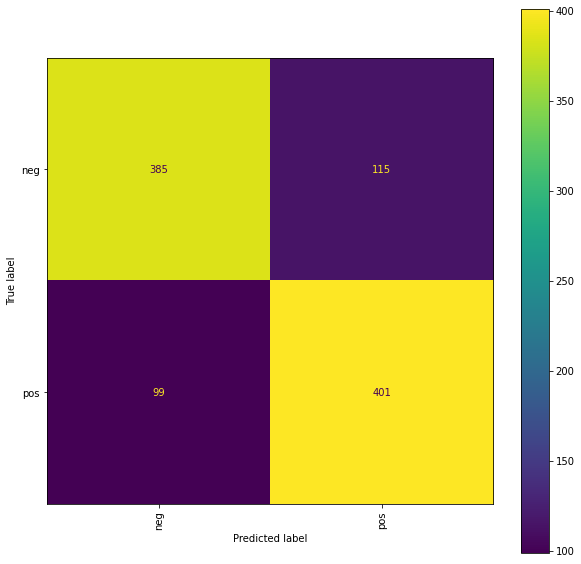

In [163]:
def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_confusion_matrix(classifier.log_reg, classifier.devX, classifier.devY, ax=ax, xticks_rotation="vertical", values_format="d")
    plt.show()

print_confusion(big_classifier)

2. Next, let's look at the features that are most defining for each of the classes (ranked by how strong their corresponding coefficient is).  Do the features you are defining help in the ways you think they should?  Do sets of successful features suggests others, or complementary features that may provide a different view on the data?

In [164]:
big_classifier.printWeights(n=25)

pos	0.653	great
pos	0.495	very
pos	0.424	best
pos	0.411	excellent
pos	0.348	man
pos	0.322	fun
pos	0.320	my
pos	0.320	also
pos	0.312	amazing
pos	0.309	enjoyed
pos	0.294	you
pos	0.287	perfect
pos	0.283	new
pos	0.277	simple
pos	0.265	relationship
pos	0.258	in
pos	0.257	performance
pos	0.245	!
pos	0.241	love
pos	0.241	saw
pos	0.236	true
pos	0.235	series
pos	0.235	'
pos	0.233	will
pos	0.231	incredible

neg	-0.617	worst
neg	-0.549	acting
neg	-0.547	even
neg	-0.482	would
neg	-0.436	?
neg	-0.431	bad
neg	-0.406	stupid
neg	-0.404	boring
neg	-0.400	waste
neg	-0.390	no
neg	-0.353	actors
neg	-0.327	watching
neg	-0.316	nothing
neg	-0.315	idea
neg	-0.315	me
neg	-0.308	there
neg	-0.305	were
neg	-0.305	horrible
neg	-0.304	poor
neg	-0.297	money
neg	-0.296	do
neg	-0.293	that
neg	-0.293	n't
neg	-0.285	awful
neg	-0.280	could



3. Next, let's look at the individual data points that are most mistaken. Does it suggest any features you might create to disentangle them?

In [165]:
def analyze(classifier):
    
    probs=classifier.log_reg.predict_proba(classifier.devX)
    predicts=classifier.log_reg.predict(classifier.devX)

    classes={}
    for idx, lab in enumerate(classifier.log_reg.classes_):
        classes[lab]=idx

    mistakes={}
    for i in range(len(probs)):
        if predicts[i] != classifier.devY[i]:
            predicted_lab_idx=classes[predicts[i]]
            mistakes[i]=probs[i][predicted_lab_idx]

    frame=[]
    sorted_x = sorted(mistakes.items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x:
        idd=classifier.devOrig[k][0]
        text=classifier.devOrig[k][2]
        frame.append([idd, v, classifier.devY[k], predicts[k], text])

    df=pd.DataFrame(frame, columns=["id", "P(predicted class confidence)", "Human label", "Prediction", "Text"])

    with option_context('display.max_colwidth', 400):
        display(df.head(n=20))


In [166]:
analyze(big_classifier)

,id,P(predicted class confidence),Human label,Prediction,Text
0,1436,0.999602,pos,neg,I have never seen such a movie before. I was on the edge of my seat and constantly laughing throughout the entire movie. I never thought such horrible acting existed it was all just too funny. The story behind the movie is decent but the movies scenes fail to portray them. I have never seen such a stupid movie in my life which is why it I think its worth watching. I give this movie 10 out of 1...
1,1784,0.971246,pos,neg,"The only complaint I have about this adaptation is that it is sexed-up. Things that were only hinted at in the novel are shown on-screen for some weird reason. Did they think the audience would be too stupid to understand if they were not shown everything out-right? Other than that, this is very good-quality. All the actors do marvelous jobs bringing their characters to life. For the shallow w..."
2,1456,0.969125,pos,neg,"Hardly a masterpiece. Not so well written. Beautiful cinematography i think not. This movie wasn't too terrible but it wasn't that much better than average. The main story dealing with highly immoral teens should have focused more on the forbidden romance and why this was... should have really gotten into it instead of scraping the surface with basically ""because mom says we can't."" Some parts..."
3,1206,0.958258,neg,pos,"Plot Synopsis: Hong Kong, 1966. Paul Wagner, the man who built the Victoria Tunnel, is murdered along with his wife by his associates. His twin sons, Chad & Alex, are split apart. 25 years later, Chad, a karate instructor in Los Angeles, & Alex, a smuggler living in Hong Kong, join forces to avenge their parents' murder & rightfully claim the tunnel.This is the second time that Jean-Claude Van..."
4,1018,0.957892,pos,neg,"This was surprisingly intelligent for a TV movie, and quite true to my own experience of bulimia. It was actually well-researched, and I can only assume it was written by someone who's gone through a similar experience, because it had all the little details. The characters were quite well-drawn, and the performances by Mare Winningham and Alison Lohman were great. I think what I like most was ..."
5,1608,0.956102,neg,pos,"As good an advert for republicanism as you're ever likely to see,""Mayerling""is an everyday story of royal folk in late nineteenth century Austria.Set during one of Europe's seemingly incessant internal turmoils it concerns itself with the Emperor Franz Joseph (Mr James Mason),his rebellious son,the Crown Prince Rudolf (Mr Omar Sharif)the Empress(Miss Ava Gardner) and various mistresses,secret ..."
6,1825,0.951981,pos,neg,"Whilst reading through the comments left for this show, I couldn't help but notice that a large percentage of the reviewers had either not actually watched any episodes of the show either all the way through or of their own free will. The thing about Kerching! is that it's a children's show, FOR CHILDREN so obviously if your older it is going to seem cheesy, forced, and probably stupid. I even..."
7,1787,0.949032,pos,neg,"My roommate had bought this documentary and invited me to watch it with her. She's from China and only heard so much about 9/11 and wanted to know the cold hard truth and she wanted me to tell her more after the documentary. I felt awful watching this documentary, it was like reliving the nightmare and it still brings tears to my eyes.But I'm extremely grateful that I watched this documentary,..."
8,1087,0.948158,pos,neg,"That's what one of the girls said at the end.Is the soccer game a metaphor for a qualifying game between the girls (or more broadly, a free-thinking group) and the authority? ""To Germany"" means to a future that's of hope? It's one of the most unforgettable cinematic experience I've ever had -- despite the crude cinematography and plot, and mild over-acting (though I like the cast -- they're lo..."
9,1982,0.947351,neg,pos,"The major flaw with the film is its uninspired script. It plods back and fo